In [341]:
import os
import time

import json

from operator import itemgetter

# data science imports
import math
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity


# utils import
from fuzzywuzzy import fuzz

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

import random

## Load Json data

In [342]:
def read_josn (path):
    file = open(path, "r", encoding = 'utf-8')
    df = []
    for line in file.readlines():
        dic = json.loads(line)
        df.append(dic)
    return df

In [343]:
# load business data
path = "data/Montréal_Data/Montréal_business.json"
business_list = read_josn(path)
# load reviews data
path = "data/Montréal_Data/Montréal_Review.json"
review_list = read_josn(path)
# load user data
path = "data/Montréal_Data/Montréal_User.json"
user_list = read_josn(path)

### Transform Json to dataframe

In [344]:
# business list into dataframe
df_business = pd.DataFrame()
business_id = []
name = []
for element in business_list:
    business_id.append(element["business_id"])
    name.append(element["name"])

Business_Num_Id = {}
U = 1
B = 1
Business_Id = []
for index in range(len(business_id)):
    if business_id[index] not in Business_Num_Id.keys():
        Business_Num_Id[business_id[index]] = B
        B = B + 1
    Business_Id.append(Business_Num_Id[business_id[index]])
    

df_business["RawBusinessId"] = business_id
df_business["businessId"] = Business_Id
df_business["title"] = name

df_business.head()

,RawBusinessId,businessId,title
0,i_oghUPqLzzJtxC6Zm-D2A,1,Braseiro
1,735UkyT4px_oeW3iyotGmA,2,Parc-nature de l'Île-de-la-Visitation
2,SWX0K1dpy4fcRq-ktZxmCg,3,Bistro des Moulins
3,spi9UEWyNrq2O4y5DD84LA,4,Restaurant Nhu Y
4,cBQDYO0dIpG6--I3DMiWoQ,5,Secrets de Femme


In [345]:
# User list into dataframe
df_user = pd.DataFrame()
user_id = []
name = []
for element in user_list:
    user_id.append(element["user_id"])
    name.append(element["name"])

User_Num_Id = {}
U = 1
User_Id = []
for index in range(len(user_id)):
    if user_id[index] not in User_Num_Id.keys():
        User_Num_Id[user_id[index]] = U
        U = U + 1
    User_Id.append(User_Num_Id[user_id[index]])
    
df_user["RawUserId"] = user_id
df_user["UserId"] = User_Id
df_user["name"] = name

df_user.head()

,RawUserId,UserId,name
0,jx-BchSqX2PlnMflR62Urw,1,Jack
1,4TCOItk-gIJROyNA5ftZ-Q,2,Alma
2,i7dva-DqwjyAtLVc2idhNA,3,Pradeep
3,U4INQZOPSUaj8hMjLlZ3KA,4,Michael
4,B4GZ3kX1TpxJUCkpPqYqng,5,Vivian


In [346]:
# review list into dataframe
df_ratings = pd.DataFrame()
#review_id = []
user_id = []
business_id = []
ratings = []
for element in review_list:
    uid = User_Num_Id[element["user_id"]]
    bid = Business_Num_Id[element["business_id"]]
    
    user_id.append(uid)
    business_id.append(bid)
    ratings.append(element["stars"])

#df_ratings["review_id"] = review_id
df_ratings["userId"] = user_id
df_ratings["businessId"] = business_id
df_ratings["rating"] = ratings

df_ratings.head()

,userId,businessId,rating
0,579,604,3.0
1,5400,91,4.0
2,1273,442,3.0
3,1202,478,5.0
4,3358,202,1.0


## Filter data
### For business

In [347]:
# get rating frequency
df_business_cnt = pd.DataFrame(df_ratings.groupby('businessId').size(), columns=['count'])
df_business_cnt.head()

,count
businessId,
1,22
2,10
3,3
4,11
5,3


In [348]:
# top quantiles of rating counts
df_business_cnt['count'].quantile(np.arange(1, 0.6, -0.05))

1.00    2348.0
0.95      84.0
0.90      51.0
0.85      35.0
0.80      27.0
0.75      21.0
0.70      16.6
0.65      14.0
Name: count, dtype: float64

In [349]:
# filter data - movies count less than 20
popularity_thres = 10
popular_business = list(set(df_business_cnt.query('count >= @popularity_thres').index))
df_ratings_drop_business = df_ratings[df_ratings.businessId.isin(popular_business)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping unpopular business: ', df_ratings_drop_business.shape)

shape of original ratings data:  (151238, 3)
shape of ratings data after dropping unpopular business:  (133714, 3)


### For users

In [350]:
# get number of ratings given by every user
df_users_cnt = pd.DataFrame(df_ratings_drop_business.groupby('userId').size(), columns=['count'])
df_users_cnt.head()

,count
userId,
1,2
2,11
3,49
4,20
5,4


In [351]:
df_users_cnt['count'].quantile(np.arange(1, 0.5, -0.05))

1.00    617.0
0.95      9.0
0.90      5.0
0.85      4.0
0.80      3.0
0.75      3.0
0.70      2.0
0.65      2.0
0.60      2.0
0.55      1.0
Name: count, dtype: float64

In [352]:
# filter data
ratings_thres = 2
active_users = list(set(df_users_cnt.query('count >= @ratings_thres').index))
df_ratings_drop_users = df_ratings_drop_business[df_ratings_drop_business.userId.isin(active_users)]
print('shape of original ratings data: ', df_ratings.shape)
print('shape of ratings data after dropping both unpopular business and inactive users: ', df_ratings_drop_users.shape)

shape of original ratings data:  (151238, 3)
shape of ratings data after dropping both unpopular business and inactive users:  (108683, 3)


In [353]:
df_ratings_drop_users.index = list(range(0, df_ratings_drop_users.shape[0]))

In [354]:
multi_index = df_ratings_drop_users.groupby(['userId', 'businessId']).count()[df_ratings_drop_users.groupby(['userId', 'businessId']).count().values != 1].index
df_aver = pd.DataFrame(columns = ['userId', 'businessId', 'aver'])
for m_index in multi_index:
    aver = np.mean(df_ratings_drop_users.loc[(df_ratings_drop_users['userId'] == m_index[0]) & (df_ratings_drop_users['businessId'] == m_index[1])]['rating'].values)
    new_row = pd.DataFrame({'userId':m_index[0], 'businessId':m_index[1], 'aver':aver}, index = [0])
    df_aver = df_aver.append(new_row)
df_aver

,userId,businessId,aver
0,3,402,2.000000
0,4,5112,5.000000
0,15,5178,5.000000
0,27,5594,5.000000
0,47,3403,3.500000
...,...,...,...
0,46677,5954,5.000000
0,46698,5722,5.000000
0,46836,5695,4.666667
0,46894,5576,4.000000


In [355]:
df_ratings_drop_users.drop_duplicates(['userId', 'businessId'], keep = False, inplace = True)
for m_index in multi_index:
    r = df_aver.loc[(df_aver['userId'] == m_index[0]) & (df_aver['businessId'] == m_index[1])]['aver'].values[0]
    new_row = pd.DataFrame({'userId':m_index[0], 'businessId':m_index[1], 'rating':r}, index = [0])
    df_ratings_drop_users = df_ratings_drop_users.append(new_row, ignore_index= True)

C:\Users\80661\AppData\Roaming\Python\Python38\site-packages\pandas\util\_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


In [356]:
print(len(np.unique(df_ratings_drop_users['userId'])))
print(len(np.unique(df_ratings_drop_users['businessId'])))

18614
2891


In [357]:
df_ratings_drop_users

,userId,businessId,rating
0,579,604,3.000000
1,5400,91,4.000000
2,1273,442,3.000000
3,1202,478,5.000000
4,3358,202,1.000000
...,...,...,...
106351,46677,5954,5.000000
106352,46698,5722,5.000000
106353,46836,5695,4.666667
106354,46894,5576,4.000000


In [358]:
df_pivot = df_ratings_drop_users.pivot(index = 'businessId', columns = 'userId', values = 'rating')
df_pivot = df_pivot.fillna(0)
df_pivot

userId,1,2,3,4,5,6,7,9,10,11,...,46887,46894,46949,46954,46957,46976,46997,47025,47038,47041
businessId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6442,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6443,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6445,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [359]:
bId = list(df_pivot.index)
uId = list(df_pivot.columns)

In [360]:
df_pivot_matrix = df_pivot.values

## Transform dataframe to dictionary

In [379]:
# Define 2 dictionaries, one is for training set, the other is for test set.
train_i = random.sample(range(df_pivot_matrix.shape[0]), round(df_pivot_matrix.shape[0]*0.75))
test_i = list(set(range(df_pivot_matrix.shape[0])) - set(random.sample(range(df_pivot_matrix.shape[0]), round(df_pivot_matrix.shape[0]*0.75))))

bId_train = [bId[i] for i in train_i]
bId_test = [bId[i] for i in test_i]

train_pivot_matrix = df_pivot_matrix.take(train_i, 0)
test_pivot_matrix = df_pivot_matrix.take(test_i, 0)

df_pivot_train = df_pivot.iloc[train_i,:]
df_pivot_test = df_pivot.iloc[test_i,:]


print('Split new trainingSet and new testSet success!')
print('TrainSet = %s' % train_pivot_matrix.shape[0])
print('TestSet = %s' % test_pivot_matrix.shape[0])

Split new trainingSet and new testSet success!
TrainSet = 2168
TestSet = 723


In [287]:
x = np.array([[3, 0, 0], [0, 4, 0], [5, 6, 0]])
np.count_nonzero(x[2])

2

## Calculate the similarity beween each 2 business 

In [298]:
def cos_sim(a, b):
    a_norm = np.linalg.norm(a)
    b_norm = np.linalg.norm(b)
    cos = np.dot(a,b)/(a_norm * b_norm)
    return cos

print(cos_sim(train_pivot_matrix[0], train_pivot_matrix[1]))

0.0


In [303]:
cosine_similarity([train_pivot_matrix[0]],[train_pivot_matrix[1]])

array([[0.]])

In [329]:
# Create business similarity matrix.
def get_business_sim_matrix(pivot_matrix, bId):
    sim_matrix = cosine_similarity(pivot_matrix, pivot_matrix)
    business_sim_matrix = {}
    for i in range(sim_matrix.shape[0]):     
        for j in range(sim_matrix.shape[1]):
            if i == j:
                continue
            business_sim_matrix.setdefault(bId[i], {})      
            business_sim_matrix[bId[i]].setdefault(bId[j], 0)
            business_sim_matrix[bId[i]][bId[j]] = sim_matrix[i][j]

    return business_sim_matrix

In [332]:
def recommend(aim_user, df_pivot, pivot_matrix, bId, norm_business_popular, alpha, cor_or_not, k=20, n=5, ):
    rank ={}
    rated_business = {}   # 找出目标用户
    
    for b in bId:
        if df_pivot.at[b, aim_user] != 0.0:
            rated_business[b] = df_pivot.at[b, aim_user]

    business_sim_matrix = get_business_sim_matrix(pivot_matrix, bId)

    for business, rating in rated_business.items():
        #遍历与物品item最相似的前k个产品，获得这些物品及相似分数
        for related_business, w in sorted(business_sim_matrix[business].items(), key=itemgetter(1), reverse=True)[:k]:
            # 若该物品用户看过， 跳过
            if related_business in rated_business:
                continue

            # 计算用户user对related_movie的偏好值， 初始化该值为0
            rank.setdefault(related_business, 0)
            #通过与其相似物品对物品related_movie的偏好值相乘并相加。
            #排名的依据—— > 推荐电影与该已看电影的相似度(累计) * 用户对已看电影的评分
            if cor_or_not == True:
                if alpha >= 0.6:
                    w = w * norm_business_popular[business]
                else:
                    w = w / (1 / norm_business_popular[business])
            rank[related_business] += w * float(rating)

    # 产生最后的推荐列表
    return sorted(rank.items(), key=itemgetter(1), reverse=True)[:n]  # itemgetter(1) 是简洁写法

Text(0.5, 1.0, 'ItemCF for prediction')

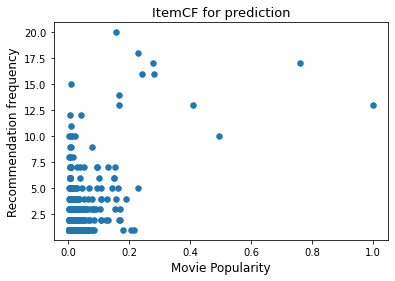

In [335]:
rec_list = []

u_100 = random.sample(uId, 100)
    
for u_id in u_100:   
    rec_list.append(recommend(u_id, df_pivot, train_pivot_matrix, bId_train, train_norm_business_popular, 0.6, False, k=20, n=20))

# Count the number of times that each business that appears in the user's recommendation list is recommended.
rec_freq = {}
for rec in rec_list:
    for b in rec:
        if b[0] not in rec_freq.keys():
            rec_freq[b[0]] = 1
        else:
            rec_freq[b[0]] = rec_freq[b[0]] + 1

# Obtain the popularity of recommended business
rec_business_popular = {}

for b in rec_freq.keys():
    rec_business_popular[b] = train_norm_business_popular[b]

# Graph the popularity of the business aginst the number of referrals.
x_popularity = list(rec_business_popular.values())
y_recommendation_frequency = list(rec_freq.values())
    
plt.scatter(x_popularity, y_recommendation_frequency,s=30,marker='o')
plt.xlabel('Movie Popularity',fontsize=12)  
plt.ylabel('Recommendation frequency',fontsize=12)
plt.title('ItemCF for prediction', fontsize=13)

In [383]:
# Recommended 20 merchants per user for 3 users
df_pivot_temp = df_pivot
pivot_matrix_temp = df_pivot.values

# Calculate the norm popularity for each business, which is how many times each business is rated by users.
norm_business_popular = {}

for i in range(pivot_matrix_temp.shape[0]):
    pop = np.count_nonzero(pivot_matrix_temp[i])
    norm_business_popular[bId[i]] = pop
        
max_pop = max(norm_business_popular.values())
min_pop = min(norm_business_popular.values())

for b, pop in norm_business_popular.items():
    norm_business_popular[b] = pop / (max_pop - min_pop)
    if norm_business_popular[b] > 1:
        norm_business_popular[b] = 1

# Calculate the popularity for each business, which is how many times each business is rated by users.
norm_business_popular_temp = norm_business_popular
u_100 = random.sample(uId, 100)
plt.figure(figsize=(16, 8))
# fig, ax = plt.subplots(1, 5)
for i in range(5):

    rec_list = []
    
    
    for u_id in u_100:   
        rec_list.append(recommend(u_id, df_pivot_temp, pivot_matrix_temp, bId, norm_business_popular_temp, 0.6, False, k=20, n=20))

    # Count the number of times that each business that appears in the user's recommendation list is recommended.
    rec_freq = {}
    for rec in rec_list:
        for b in rec:
            if b[0] not in rec_freq.keys():
                rec_freq[b[0]] = 1
            else:
                rec_freq[b[0]] = rec_freq[b[0]] + 1

    # Obtain the popularity of recommended business.
    rec_business_popular = {}

    for b in rec_freq.keys():
        rec_business_popular[b] = norm_business_popular_temp[b]

    x_popularity = list(rec_business_popular.values())
    y_recommendation_frequency = list(rec_freq.values())

    plt.subplot(2, 3, i + 1)
    plt.scatter(x_popularity, y_recommendation_frequency,s=30,marker='o')
    plt.xlabel('Movie Popularity',fontsize=12)  
    plt.ylabel('Recommendation frequency',fontsize=12)
    plt.title('ItemCF for prediction ' + str(i+1), fontsize=13)
    print("Graph " + str(i+1) + " has been generated.")

    # Update the user rating matrix.
    for j in range(len(u_100)):
        for b in rec_list[j]:
            b_id = b[0]
            r = b[1]
            df_pivot_temp.at[b_id, u_100[j]] = r
    
    pivot_matrix_temp = df_pivot_temp.values
    
    # Update the business popularity.
    norm_business_popular_temp = {}
    for i in range(pivot_matrix_temp.shape[0]):
        pop = np.count_nonzero(pivot_matrix_temp[i])
        norm_business_popular_temp[bId[i]] = pop
        
    max_pop = max(norm_business_popular_temp.values())
    min_pop = min(norm_business_popular_temp.values())

    for b, pop in norm_business_popular_temp.items():
        norm_business_popular_temp[b] = pop / (max_pop - min_pop)
        if norm_business_popular_temp[b] > 1:
            norm_business_popular_temp[b] = 1

plt.show()
plt.suptitle("Item CF after adding penalty")

Graph 1 has been generated.
Graph 2 has been generated.


In [366]:
a = pd.DataFrame(np.arange(15).reshape(5,3), columns=list('ABC'), index=list('abcde'))
a

,A,B,C
a,0,1,2
b,3,4,5
c,6,7,8
d,9,10,11
e,12,13,14


In [371]:
a.iloc[[0, 2, 4],:]

,A,B,C
a,0,1,2
c,6,7,8
e,12,13,14


In [ ]:
# Recommended 20 merchants per user for 3 users
df_pivot_temp = df_pivot
pivot_matrix_temp = df_pivot.values

# Calculate the norm popularity for each business, which is how many times each business is rated by users.
norm_business_popular = {}

for i in range(pivot_matrix_temp.shape[0]):
    pop = np.count_nonzero(pivot_matrix_temp[i])
    norm_business_popular[bId[i]] = pop
        
max_pop = max(norm_business_popular.values())
min_pop = min(norm_business_popular.values())

for b, pop in norm_business_popular.items():
    norm_business_popular[b] = pop / (max_pop - min_pop)
    if norm_business_popular[b] > 1:
        norm_business_popular[b] = 1

# Calculate the popularity for each business, which is how many times each business is rated by users.
norm_business_popular_temp = norm_business_popular
u_100 = random.sample(uId, 100)
plt.figure(figsize=(16, 8))
# fig, ax = plt.subplots(1, 5)
for i in range(5):

    rec_list = []
    
    
    for u_id in u_100:   
        rec_list.append(recommend(u_id, df_pivot_temp, pivot_matrix_temp, bId, norm_business_popular_temp, 0.6, True, k=20, n=20))

    # Count the number of times that each business that appears in the user's recommendation list is recommended.
    rec_freq = {}
    for rec in rec_list:
        for b in rec:
            if b[0] not in rec_freq.keys():
                rec_freq[b[0]] = 1
            else:
                rec_freq[b[0]] = rec_freq[b[0]] + 1

    # Obtain the popularity of recommended business.
    rec_business_popular = {}

    for b in rec_freq.keys():
        rec_business_popular[b] = norm_business_popular_temp[b]

    x_popularity = list(rec_business_popular.values())
    y_recommendation_frequency = list(rec_freq.values())
    
    plt.subplot(2, 3, i + 1)
    plt.scatter(x_popularity, y_recommendation_frequency,s=30,marker='o')
    plt.xlabel('Movie Popularity',fontsize=12)  
    plt.ylabel('Recommendation frequency',fontsize=12)
    plt.title('ItemCF for prediction ' + str(i+1), fontsize=13)
    print("Graph " + str(i+1) + " has been generated.")

    # Update the user rating matrix.
    for j in range(len(u_100)):
        for b in rec_list[j]:
            b_id = b[0]
            r = b[1]
            df_pivot_temp.at[b_id, u_100[j]] = r
    
    pivot_matrix_temp = df_pivot_temp.values
    
    # Update the business popularity.
    norm_business_popular_temp = {}
    for i in range(pivot_matrix_temp.shape[0]):
        pop = np.count_nonzero(pivot_matrix_temp[i])
        norm_business_popular_temp[bId[i]] = pop
        
    max_pop = max(norm_business_popular_temp.values())
    min_pop = min(norm_business_popular_temp.values())

    for b, pop in norm_business_popular_temp.items():
        norm_business_popular_temp[b] = pop / (max_pop - min_pop)
        if norm_business_popular_temp[b] > 1:
            norm_business_popular_temp[b] = 1

plt.show()
plt.suptitle("Item CF after adding penalty")

KeyboardInterrupt: 

<Figure size 1152x576 with 0 Axes>